In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import style
style.use('seaborn-white')
import pandas as pd
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy import units as u
from astropy.table import QTable
import tarfile
import sqlite3
import lsst.daf.persistence as dafPersist
from lsst.daf.base import DateTime
#import diaObjectAnalysis as doa
#import plotLightcurve as plc
#import apdbPlots as pla
import scipy
sys.path.append('/epyc/users/mrawls/premap2019/ap_pipe-notebooks/')
from apdbPlots import makeSrcTableFlags
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [2]:
hitsDataDir='/epyc/users/mrawls/premap2019/hits-dr1'
hitsFilename='HiTS_DR1_variables_DM-dataset-subset.fits'
hitsFilepath=os.path.join(hitsDataDir,hitsFilename) # Creates file path to the HiTS DR1 database
hitsTable=fits.open(hitsFilepath) # Load data as an astropy fits thing
hitsDf=pd.DataFrame(hitsTable[1].data) # Turn data into a pandas dataframe

In [3]:
hitsDfQSO_filter = hitsDf[hitsDf['QSO_Prob'] > 0.80]
hitsDfQSO = hitsDfQSO_filter.drop(['Variable_prob', 'Periodic_prob', 'DSCT_Prob', 'EB_Prob', 'Predicted_class',
                                   'ROTVAR_Prob', 'RRLYR_Prob', 'CV_Prob', 'SNe_Prob'], axis = 1)

In [4]:
repo = '/epyc/users/mrawls/hits2015/rerun/cw_2020_02'
butler = dafPersist.Butler(repo) # Butler function retrieves the data
dbName = 'association.db'
dbPath = os.path.join(repo, dbName) # Joins repo and dbName to form a path to the database
connection = sqlite3.connect(dbPath) # Opens a connection to the database

# Read data from the database to pandas dataframes
objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources, \
                              gPSFluxMean, gPSFluxMeanErr, \
                              validityEnd, flags, \
                              gTOTFluxMean, gTOTFluxMeanErr \
                              from DiaObject where validityEnd is NULL;', connection) 
srcTableAll = pd.read_sql_query('select diaSourceId, diaObjectId, \
                                  ra, decl, ccdVisitId, \
                                  midPointTai, apFlux, psFlux, apFluxErr, \
                                  psFluxErr, totFlux, totFluxErr, flags \
                                  from DiaSource;', connection)

In [15]:
MILLI_all_filtered = pd.read_csv('/epyc/users/tw94/lsst-hits-bump/mrawls/MILLI_all_filtered.csv')
MILLI_all_filtered.head()

,ra,dec,ra_deg,dec_deg,bmag,rmag,redshift,radio_name,xray_name,lii,...,optical_flag,red_psf_flag,blue_psf_flag,ref_name,ref_redshift,qso_prob,class,idx,d2d_deg,diaObjectId
0,09 57 23.69,+01 14 58.7,149.348708,1.249639,19.73,19.44,2.484,,,237.26096,...,jG,-,-,DR14Q,DR14Q,,QSO TYPE 1,39116,0.234868,176486889161752879
1,10 03 05.70,+01 15 03.5,150.773750,1.250972,20.98,19.83,0.748,,,238.38186,...,pG,-,-,2QZ,2QZ,,QSO TYPE 1,18215,0.185993,176547031588798698
2,10 00 18.59,+01 15 06.1,150.077458,1.251694,21.36,19.95,0.861,,,237.82779,...,pG,-,-,2QZ,2QZ,,QSO TYPE 1,3314,0.137841,176547035883766087
3,09 56 47.47,+01 15 23.9,149.197792,1.256639,17.39,14.58,0.064,FIRST J095647.4+011523,,237.13686,...,p+G,1,1,PGC,DR16,100,AGN UNCLASSIFIED,39116,0.354526,176486889161752879
4,10 02 07.77,+01 15 27.2,150.532375,1.257556,21.19,20.37,2.517,,,238.18185,...,jG,1,-,DR14Q,DR14Q,,QSO TYPE 1,31159,0.000027,176486914931556904


## Plotting All the Things

In [16]:
def plotLSSTLightcurve(diaObjectId, dbPath='/epyc/users/mrawls/hits2015/rerun/cw_2020_02/association.db'):
    '''Plot a light curve for a DIA (Difference Image Analysis) Object
    from an LSST APDB (Alert Production database).
    
    Parameters
    ----------
    diaObjectId : Identifier for an LSST DIA object
    
    dbPath : Path on disk to an APDB we can load DIA Objects or DIA Sources from
        often the database is named `association.db`

    '''
        
    # Load all sources for this object only
    connection = sqlite3.connect(dbPath)
    forcedSrcTable = pd.read_sql_query(f'select diaObjectId, midPointTai, psFlux, psFluxErr, totFlux, totFluxErr \
                                       from DiaForcedSource where diaObjectId = {diaObjectId};', connection)
    srcTable = pd.read_sql_query(f'select diaObjectId, midPointTai, ccdVisitId, psFlux, psFluxErr, totFlux, totFluxErr \
                                 from DiaSource where diaObjectId = {diaObjectId};', connection)

    # Convert flux to magnitude
    #mags = (np.array(forcedSrcTable['totFlux'])*u.nJy).to(u.ABmag)
    #magErrs = 1.0857 / forcedSrcTable['totFluxErr'] / forcedSrcTable['totFlux']
    #forcedSrcTable['mags'] = mags
    #forcedSrcTable['magErrs'] = magErrs
    
    #mags = (np.array(srcTable['totFlux'])*u.nJy).to(u.ABmag)
    #magErrs = 1.0857 / srcTable['totFluxErr'] / srcTable['totFlux']
    #srcTable['mags'] = mags
    #srcTable['magErrs'] = magErrs
    
    plt.figure(figsize=(10,4))
    
  
  
    # Plot the LSST light curve (forced PSF photometry on calexp at DIASource position)
    plt.errorbar(srcTable['midPointTai'], srcTable['totFlux'], 
                 yerr=srcTable['totFluxErr'], ls=':', marker='o', label='LSST Source', color='C0')
    
    # Plot the LSST light curve (forced PSF photometry on calexp at DIAObject position)
    #plt.errorbar(forcedSrcTable['midPointTai'], forcedSrcTable['totFlux'], 
     #            yerr=forcedSrcTable['totFluxErr'], ls=':', marker='o', label='LSST', color='C0')
    
    # Plot the LSST light curve directly from source catalogs
    #if plotSourceCatLightCurve:
       # objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources \
        #                      from DiaObject where validityEnd is NULL;', connection)
       # sourceCatTimes, sourceCatMags, sourceCatMagErrs = getSourceCatLightCurve(obj, objTable, srcTable, butler)
       # plt.errorbar(sourceCatTimes, sourceCatMags, yerr=sourceCatMagErrs, ls=':', marker='o', label='LSST SourceCat', color='C2')
    
    

    # Add some plot labels, and reverse the y-axis so bright stuff is at the top
    plt.xlabel('Time (MJD)')
    plt.ylabel('Instantaneous Flux (nJy)')
    #plt.legend(frameon=False, prop={'size': 16})

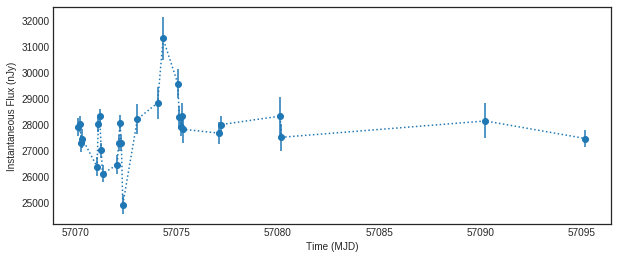

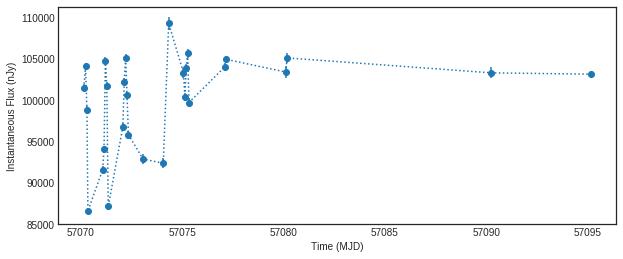

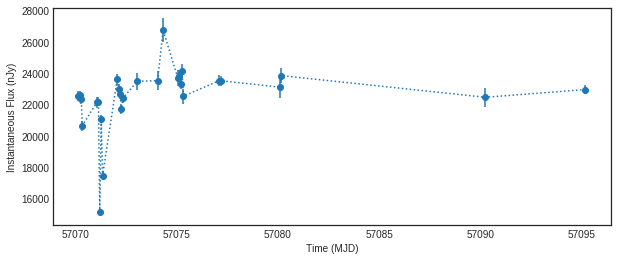

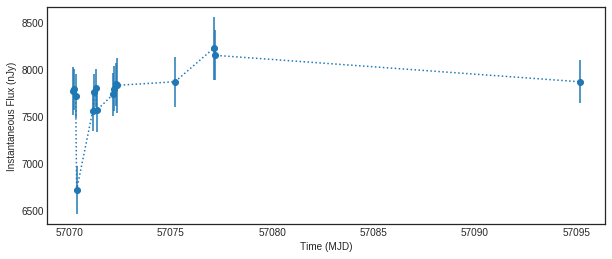

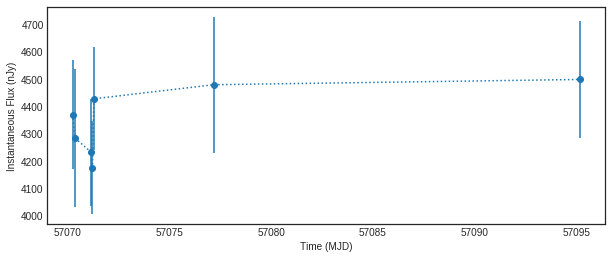

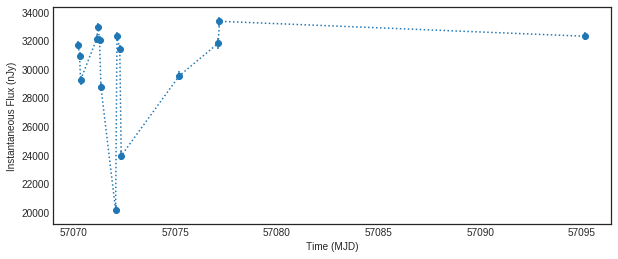

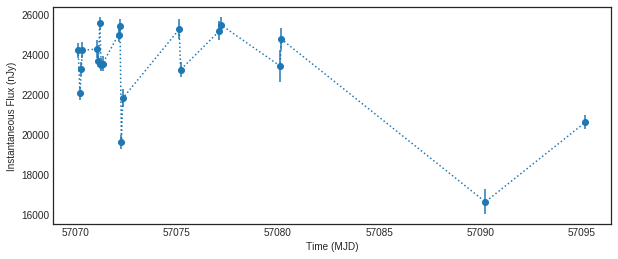

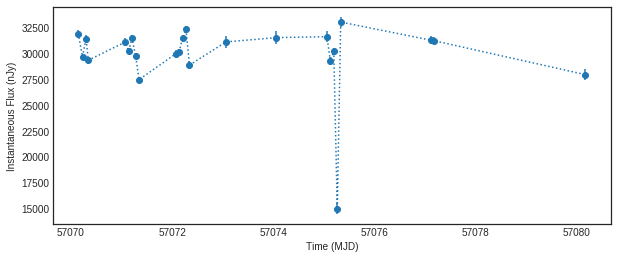

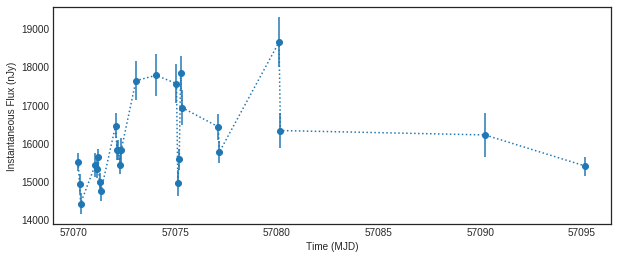

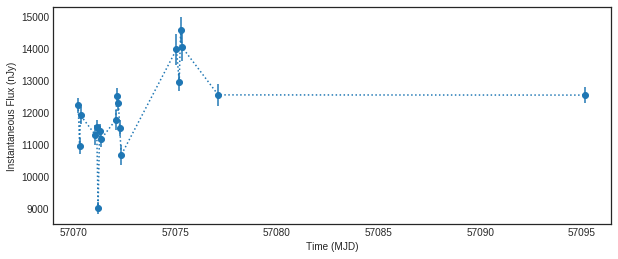

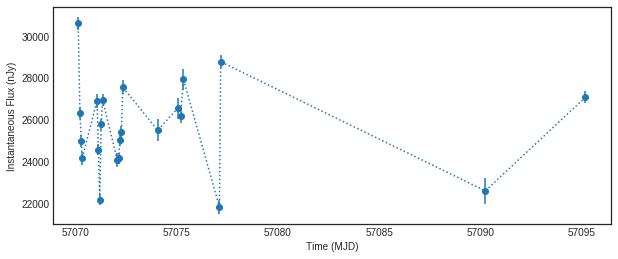

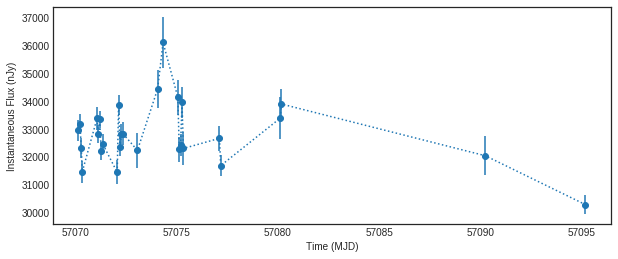

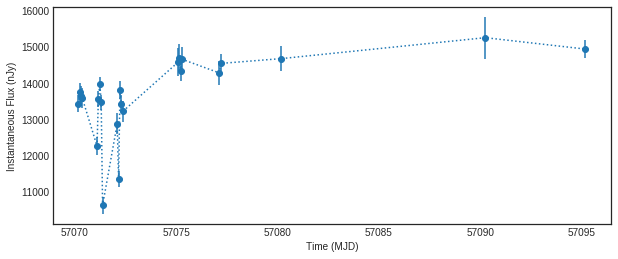

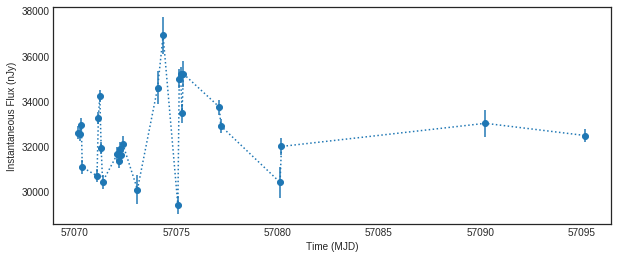

In [17]:
for obj in MILLI_all_filtered['diaObjectId'].loc[MILLI_all_filtered['d2d_deg'] < 0.00001]:
     plotLSSTLightcurve(obj)

#### Trying to make Meredith's cool plot

In [26]:
dataId = {'visit': 413696, 'ccd': 47}
#calexp = butler.get('calexp', dataId = dataId)
#src = butler.get('src', dataId = dataId)
#psfRadius = calexp.getPsf().computeShape().getDeterminantRadius()

In [30]:
dataId={'visit':413696,'ccdnum':47 }
processedImage=butler.get('calexp', dataId=dataId)

NoResults: No locations for get: datasetType:calexp dataId:DataId(initialdata={'visit': 413696, 'ccdnum': 47}, tag=set())